# Analyze Delta 2.0 Data for *Pseudomonas syringae*
 
In this notebook we filter, quantifify and visualize the time-lapse data of Pseudomonas syringae growing on agar-pads

---

## Import packages

In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns
import pathlib

import scipy
from scipy.stats import pearsonr, linregress

---

## Setup Folders

In [42]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'Documents/Image_analysis/Pseudomonas/Lopez-Pagan2024/Output')
data_dir = proj_dir / 'data_files'

image_dir = proj_dir / 'figures_Psy'
(image_dir).mkdir(exist_ok=True) #create output data folder

save_dir = proj_dir / 'data_files'

---

## Load Data

We also add a unique ID for each cell pair (two cells with shared parent) by combining strain id, replicate id, and par id

In [43]:
#load data frame
df_name = data_dir / 'Psy_combined_data.csv'
df = pd.read_csv(df_name, index_col=0)

#add unique id of cell and parent cell by combining strain and replicate
df['uni_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_cell'].map(str)
df['uni_par_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_par'].map(str)
df.head()

/var/folders/8m/n060yz8109z9b7jqt7thhbjh0000gp/T/ipykernel_47012/3379780654.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_name, index_col=0)


,index,Unnamed: 0,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,...,fluo1,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id,uni_par_id
0,0,0,0,0,-1,0,1,31,-1,0,...,1117.945080,818.869565,549.830664,0.0,0,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,Psy-eGFP-0-0,Psy-eGFP-0--1
1,1,1,0,0,-1,0,1,31,-1,1,...,1223.422222,823.174444,553.876667,0.0,1,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,Psy-eGFP-0-0,Psy-eGFP-0--1
2,2,2,0,0,-1,0,1,31,-1,2,...,1220.245108,827.603502,553.126674,0.0,2,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,Psy-eGFP-0-0,Psy-eGFP-0--1
3,3,3,0,1,0,0,2,65,31,3,...,1192.571116,858.800875,535.859956,1.0,0,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,Psy-eGFP-0-1,Psy-eGFP-0-0
4,4,4,0,1,0,0,2,65,31,4,...,1218.981752,866.724453,533.315693,1.0,1,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,Psy-eGFP-0-1,Psy-eGFP-0-0


In [44]:
print(list(df.columns))

['index', 'Unnamed: 0', 'id_seg', 'id_cell', 'id_par', 'id_colony', 'id_d1', 'id_d2', 'id_sib', 'frames', 'new_pole', 'old_pole', 'edges', 'length', 'width', 'area', 'perimeter', 'fluo1', 'x_pos', 'y_pos', 'generation', 'age', 'strain', 'movie_name', 'replicate', 'uni_id', 'uni_par_id']


---

## Check data

We first plot the life time distribution full lineages (those with parent and two offspring)


,index,Unnamed: 0,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,...,fluo1,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id,uni_par_id
3,3,3,0,1,0,0,2,65,31,3,...,1192.571116,858.800875,535.859956,1.0,0,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,Psy-eGFP-0-1,Psy-eGFP-0-0
4,4,4,0,1,0,0,2,65,31,4,...,1218.981752,866.724453,533.315693,1.0,1,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,Psy-eGFP-0-1,Psy-eGFP-0-0
5,5,5,0,1,0,0,2,65,31,5,...,1253.086957,870.441224,534.708535,1.0,2,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,Psy-eGFP-0-1,Psy-eGFP-0-0
6,6,6,0,1,0,0,2,65,31,6,...,1278.014019,876.246106,530.908100,1.0,3,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,Psy-eGFP-0-1,Psy-eGFP-0-0
7,7,7,0,1,0,0,2,65,31,7,...,1302.479685,866.515072,518.393185,1.0,4,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,Psy-eGFP-0-1,Psy-eGFP-0-0


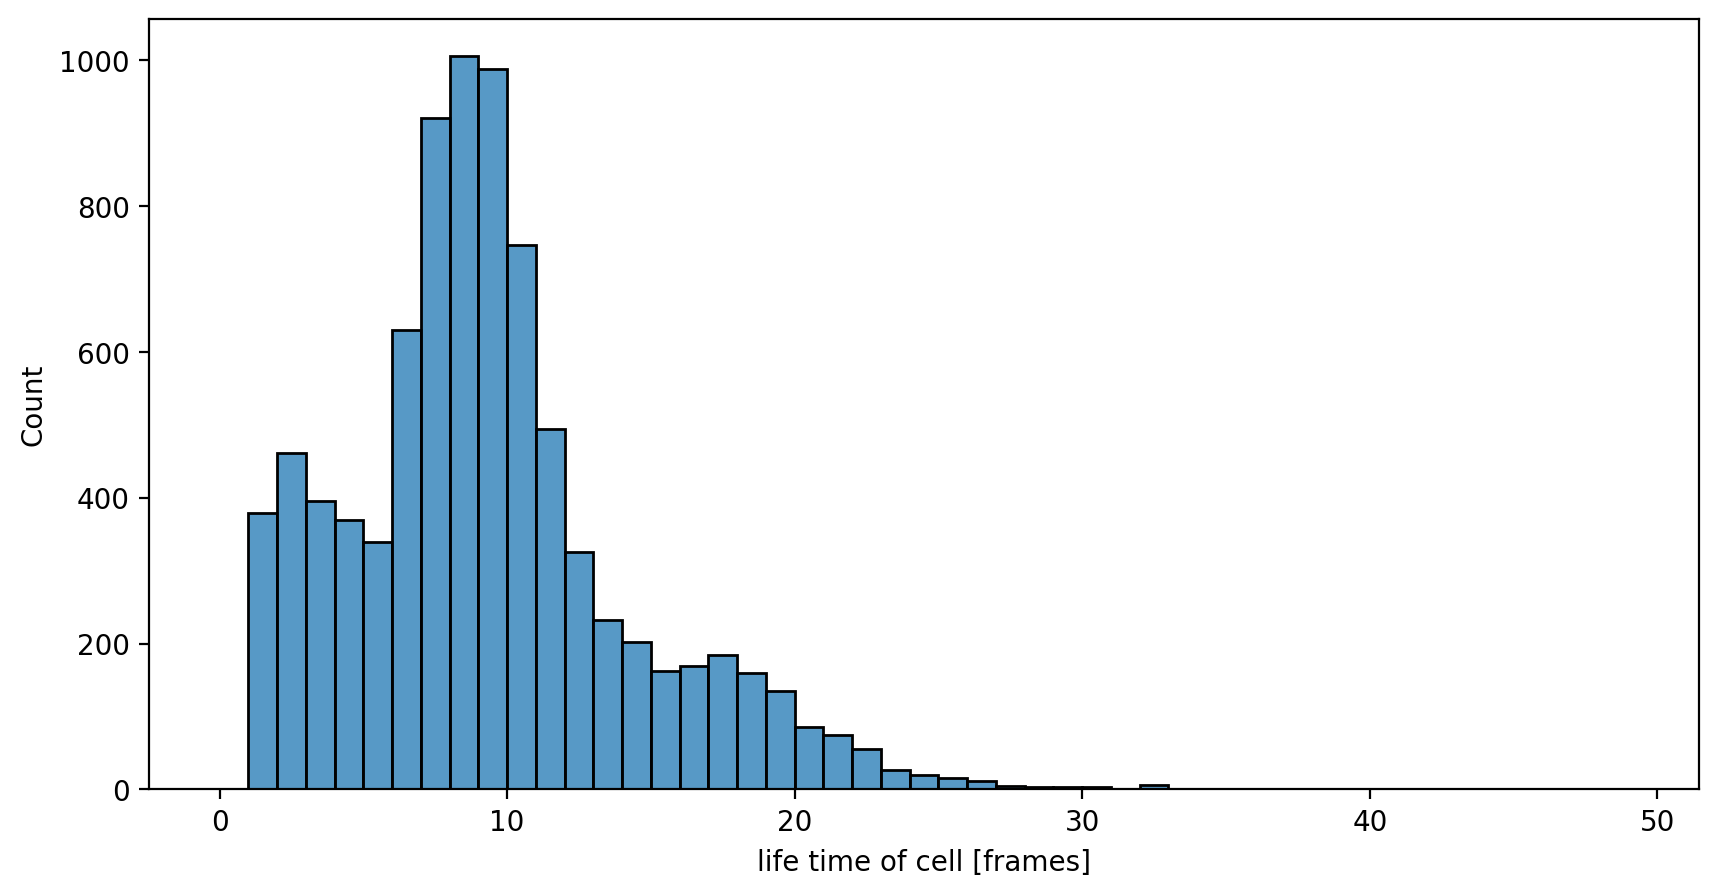

In [45]:
#plot cell life_time for full lineages
has_mom = df["id_par"] > -1
has_d1 = df["id_d1"] > -1
has_d2 = df["id_d2"] > -1
full_lin = has_mom & has_d1 & has_d2

df_compl = df[full_lin].copy()
ax = sns.histplot(data=df_compl.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]');

df_compl.head()

Next we analyze the change in length between two frames

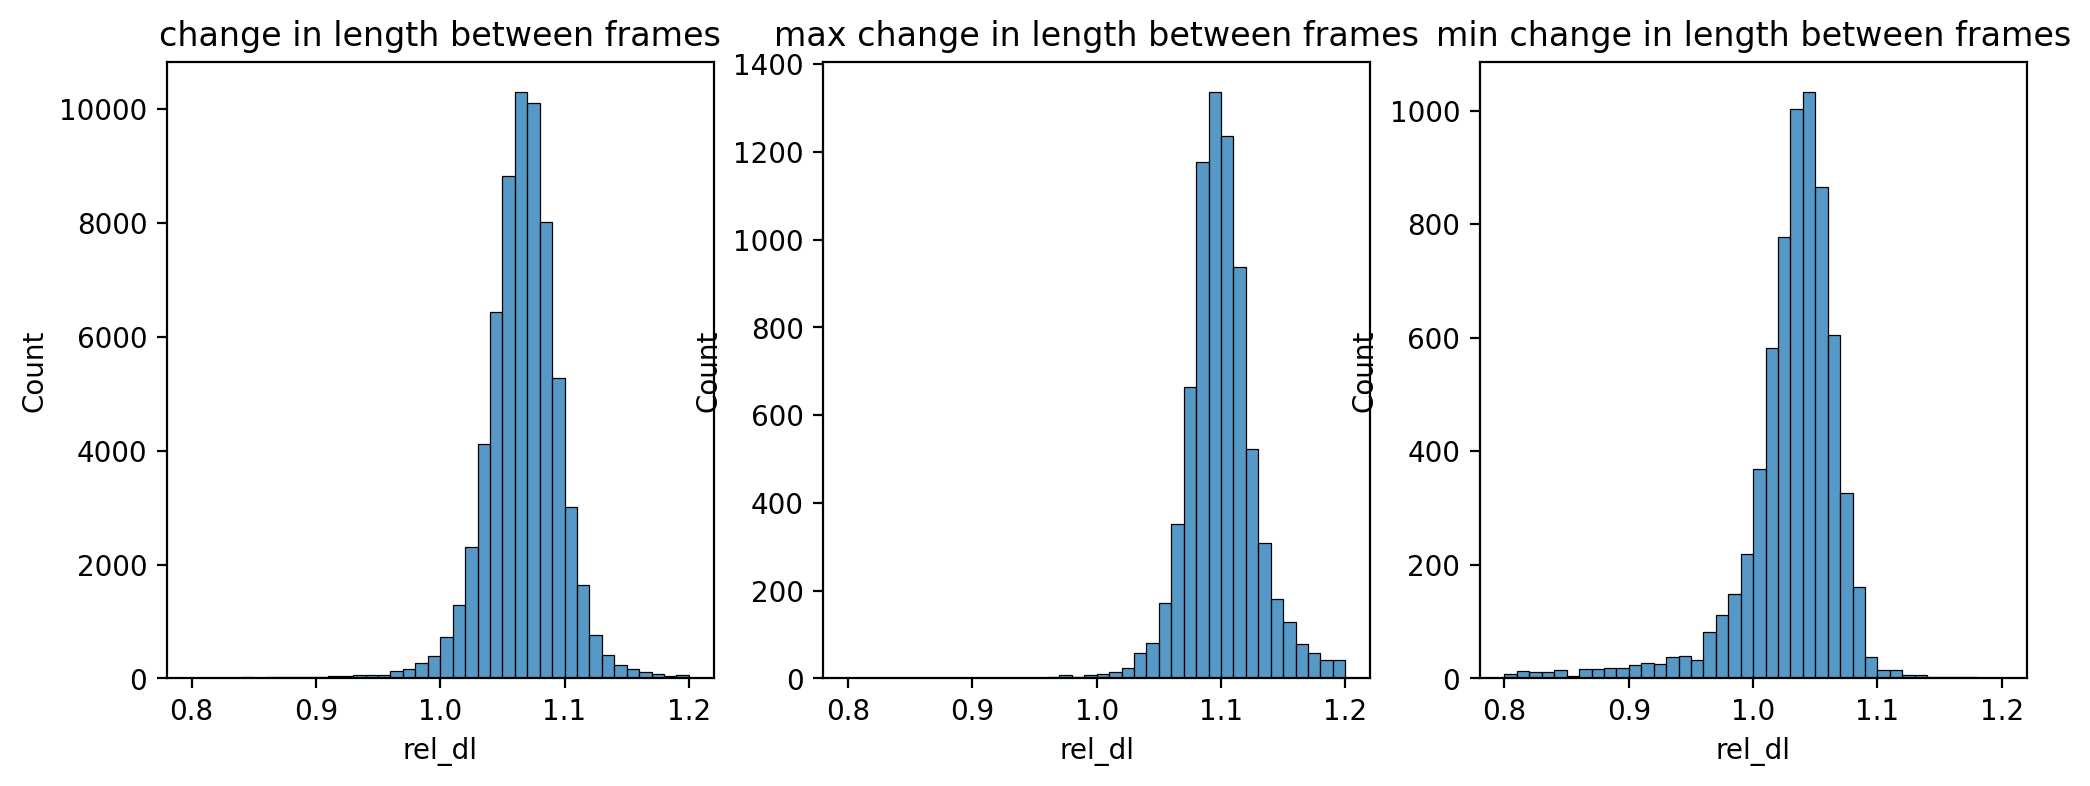

In [46]:
#calc length change
dl = df_compl.groupby('uni_id')['length'].diff()
df_compl['rel_dl'] = (df_compl['length'] + dl)/df_compl['length']
max_dl = df_compl.groupby('uni_id')['rel_dl'].max()
min_dl = df_compl.groupby('uni_id')['rel_dl'].min()

fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axs[0], data=df_compl, x='rel_dl', bins=np.linspace(0.8,1.2,41)).set(title='change in length between frames')
sns.histplot(ax=axs[1], data=max_dl, bins=np.linspace(0.8,1.2,41)).set(title='max change in length between frames')
sns.histplot(ax=axs[2], data=min_dl, bins=np.linspace(0.8,1.2,41)).set(title='min change in length between frames');

Next we analyze the change in length across cell divisions 

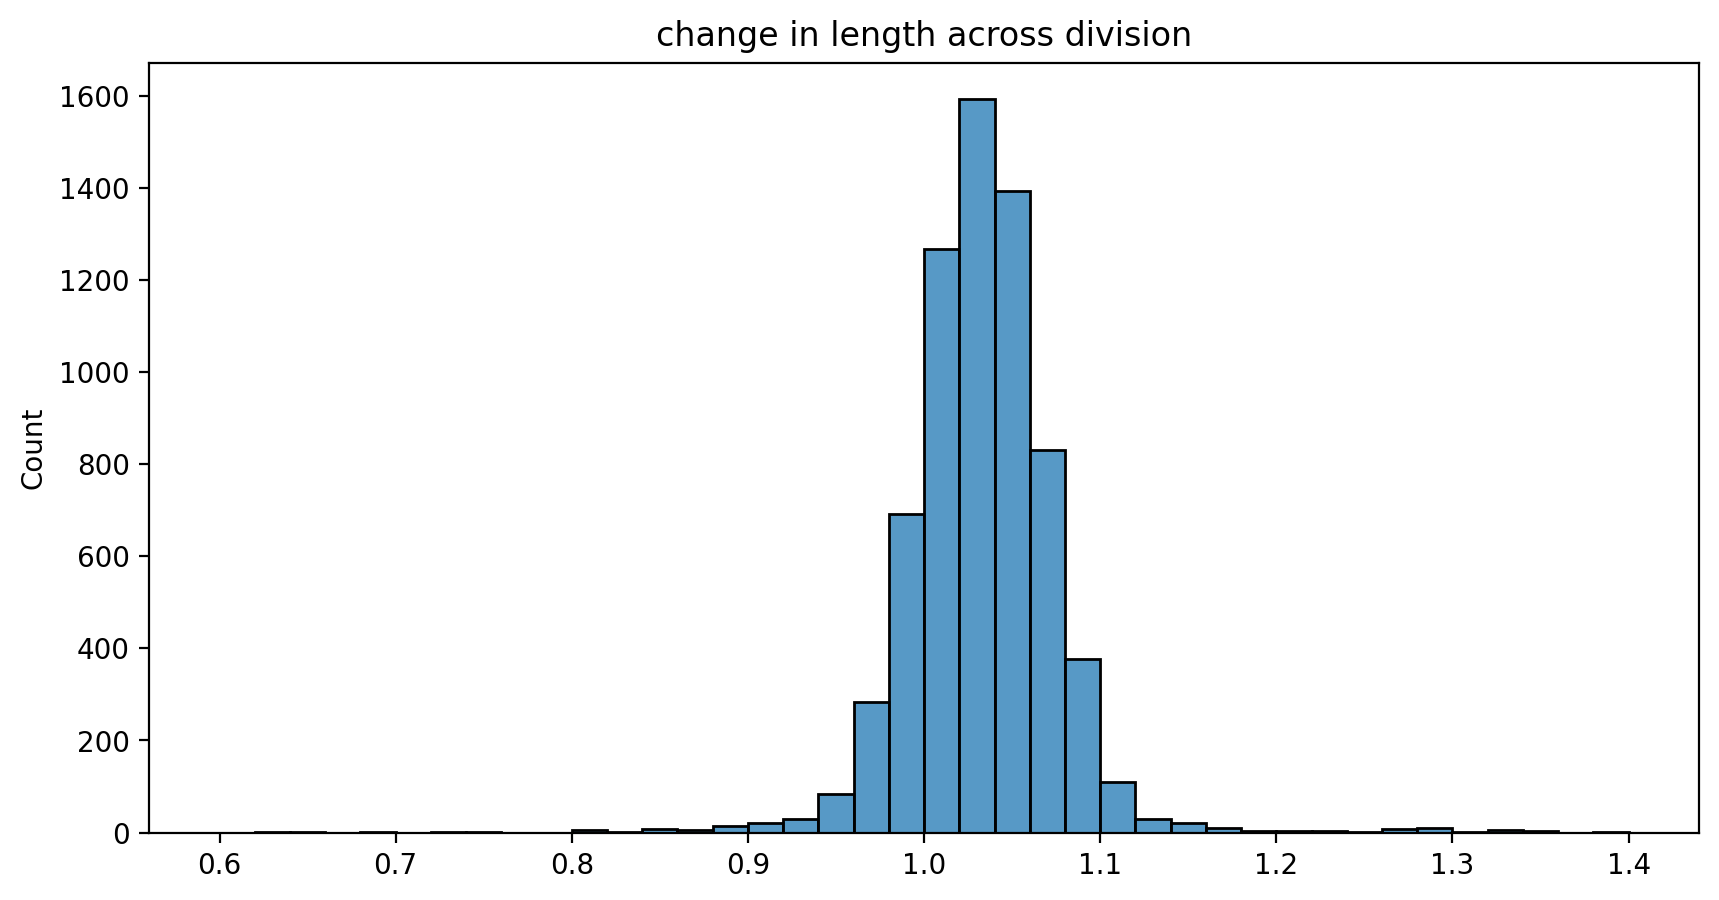

In [47]:
#analyze change in length
dl_list = []
movies_grouped = df_compl.groupby('movie_name')

for name, movie in movies_grouped:
    cells_grouped = movie.groupby('uni_id')
    for name, cell in cells_grouped:
        
        try:
            sis_idx = movie['id_cell'] == cell['id_sib'].iloc[0]
            par_idx = movie['id_cell'] == cell['id_par'].iloc[0]
            
            #get length
            len_cel = cell['length'].iloc[0]
            len_sib = movie.loc[sis_idx, 'length'].iloc[0]
            len_par = movie.loc[par_idx, 'length'].iloc[-1]
        
            dl_list.append((len_cel + len_sib) / len_par) #Get cell gowth during division
        except:
            continue
        
sns.histplot(data=dl_list, bins=np.linspace(0.6,1.4,41)).set(title='change in length across division');

---

## Filter data

We use following checks:

 - We only consider cells whose division is properly tracked (both daughters are identified) and where both offspring cells are tracked for at least `min_num_frm` frames
 - We filter out lineages where length changes too much between division
   - We calculate length change as $\frac{l_{d1}+l_{d2}}{l_p}$
 - We filter out lineages where the length changes too much during life time
    - We calculate length change as $\frac{l(t+\Delta t)}{l(t)} = 2^{\Delta t / t_d}$

In [48]:
dt = 15/60 #pictures every 15 min (0.25 hours between two timeframes)

def check_growth(len_d, min_dl, max_dl):
    
    """Check if change in length between frames stays within bounds

    Parameters
    ----------
    len : np.array
        length of cell over time
    min_dl : float
        lowest value of l(t+1)/l(t) that is allowed
    max_dl : float
        highest value of l(t+1)/l(t) that is allowed

    Returns
    -------
    Boolean
        True if  min_dl < l(t+1)/l(t) < max_dl for all t; false otherwise
    """
    dl = len_d[1:] / len_d[0:-1]
    return np.all(dl>min_dl) & np.all(dl<max_dl)


def filter_tracks(movie, par_cell, filter_par, reason_skipped):
    """Filter cell tracks based on criteria

    Parameters
    ----------
    movie : pd.DataFrame 
        grouped by DataFrame containing data of single position
    par_cell : pd.DataFrame 
        grouped by DataFrame containing data of single cell, whose offspring will be analyzed
    filter_par : dictionary
        dictionary with filter parameter
    reason_skipped : dictionary
        dictionary that tracks reason why cell was skipped 

    Returns
    -------
    pd.DataFrame or None
        If tracking passes all criteria output is a DataFrame containing paired data of both offspring cells of par_cell, else a None is returned 
    """
    
    #init output
    new_df = None
    
    #check if division was tracked
    has_d1 = par_cell["id_d1"].iloc[0] > -1
    has_d2 = par_cell["id_d2"].iloc[0] > -1
    paired_lin = has_d1 & has_d2
    if not paired_lin: reason_skipped['division not tracked'] += 1

    if paired_lin:
        #get offspring cells (d1 and d2)
        d1_idx = movie['id_cell'] == par_cell["id_d1"].iloc[0]
        d2_idx = movie['id_cell'] == par_cell["id_d2"].iloc[0]
    
        #check if both offspring cells have been tracked for enough frames
        len_d1 = movie.loc[d1_idx, 'length']
        len_d2 = movie.loc[d2_idx, 'length']
        len_ok = (len_d1.size >= filter_par['min_num_frm']) & (len_d2.size >= filter_par['min_num_frm']) 
        if not len_ok: reason_skipped['too few frames'] +=1

        if len_ok:
            #check length change across division          
            dl = (len_d1.iloc[0] + len_d2.iloc[0]) / par_cell['length'].iloc[-1]
            div_ok = (dl > filter_par['min_dl_div']) &  (dl < filter_par['max_dl_div'])
            if not div_ok: reason_skipped['dL error at div.'] +=1
            
            if div_ok:
                #crop movies to shortest length #??? not needed if interested in the whole cell growth of both daughters?
                #frms = np.arange(min(len_d1.size, len_d2.size))
                frms_d1 = np.arange(len_d1.size)
                frms_d2 = np.arange(len_d2.size)
                len_d1 = len_d1.iloc[frms_d1].values
                len_d2 = len_d2.iloc[frms_d2].values
                
                #check length change over time  
                len_ok = check_growth(len_d1, filter_par['min_dl'], filter_par['max_dl']) & \
                        check_growth(len_d2, filter_par['min_dl'], filter_par['max_dl'])
                if not len_ok: reason_skipped['dL error'] +=1

                if len_ok:
                    #cell pair ok, process
                    reason_skipped['properly tracked'] +=1
                    
                    id_d1 = par_cell["id_d1"].iloc[0]
                    id_d2 = par_cell["id_d2"].iloc[0]
                    
                    #copy data frame   
                    cell_d1 = movie.loc[d1_idx, :]
                    new_df = cell_d1.iloc[frms_d1, df.columns.get_indexer(cols)].reset_index(drop=True)
                    
                    #get fluorescent values of gfp
                    fluo_d1 = cell_d1[filter_par['gfp_ch']].iloc[frms_d1].values 
                    fluo_d2 = movie.loc[d2_idx, filter_par['gfp_ch']].iloc[frms_d2].values 

                    #create new columns with relevant paramters
                    new_df['fluo1_avg'] =  np.mean(new_df['fluo1'])
                    new_df['lifetime'] = max(new_df['age'])*dt
                    new_df['elongation_rate'] = np.log10(new_df['length'].iloc[-1]/new_df['length'].iloc[0]) / new_df['lifetime'] #in pixels / hour
                    
                    #Do a linear regression to get elongation rate 
                    #This is more robust than comparing birth and death lengths due to potentialsegmentation issues
                    new_df['elongation_rate_linreg'] = linregress(new_df['age'],np.log(new_df['length'])).slope / dt #log-transform because growth is exponential
                    new_df = new_df.loc[new_df['elongation_rate_linreg'] > 0,:] #Only keep cells actively growing (eg with an elongation rate > 0)
    return new_df

In [49]:
#filter settings
filter_par = {
        'max_dl': 1.2,  
        'min_dl': 0.8,  
        'max_dl_div': 1.2,
        'min_dl_div': 0.8, 
        'min_num_frm': 4,
        'gfp_ch': 'fluo1'}

#columns to copy
cols = ['uni_par_id', 'uni_id', 'strain', 'movie_name', 'replicate', 'id_colony', 
        'id_par', 'frames', 'length', 'area', 'generation', 'age','fluo1']

#keep track of why lineages are skipped
reason_skipped = { \
        'division not tracked':0,
        'too few frames':0,
        'dL error at div.':0,
        'dL error':0,
        'properly tracked':0}

#init output
df_list = []
#loop movies
movies_grouped = df.groupby('movie_name')
for _, movie in movies_grouped: 
#loop by parent cells
    cells_grouped = movie.groupby('uni_par_id') 
    for _, par_cell in cells_grouped:
        # filter cells    
        new_df = filter_tracks(movie, par_cell, filter_par, reason_skipped)
        if new_df is not None:
                df_list.append(new_df)
                
df_paired = pd.concat(df_list)
df_paired.head(10)

,uni_par_id,uni_id,strain,movie_name,replicate,id_colony,id_par,frames,length,area,generation,age,fluo1,fluo1_avg,lifetime,elongation_rate,elongation_rate_linreg
0,Psy-eGFP-0-1,Psy-eGFP-0-2,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,0,1,13,67.197899,629.5,2.0,0,1821.661360,1858.524698,1.5,0.149054,0.350100
1,Psy-eGFP-0-1,Psy-eGFP-0-2,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,0,1,14,74.965256,690.0,2.0,1,1764.782781,1858.524698,1.5,0.149054,0.350100
2,Psy-eGFP-0-1,Psy-eGFP-0-2,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,0,1,15,79.953644,748.5,2.0,2,1717.295482,1858.524698,1.5,0.149054,0.350100
3,Psy-eGFP-0-1,Psy-eGFP-0-2,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,0,1,16,87.720261,806.5,2.0,3,1823.748869,1858.524698,1.5,0.149054,0.350100
4,Psy-eGFP-0-1,Psy-eGFP-0-2,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,0,1,17,98.491325,934.0,2.0,4,1895.941176,1858.524698,1.5,0.149054,0.350100
5,Psy-eGFP-0-1,Psy-eGFP-0-2,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,0,1,18,106.260307,1057.0,2.0,5,1982.651607,1858.524698,1.5,0.149054,0.350100
6,Psy-eGFP-0-1,Psy-eGFP-0-2,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,0,1,19,112.444244,1070.0,2.0,6,2003.591610,1858.524698,1.5,0.149054,0.350100
0,Psy-eGFP-0-2,Psy-eGFP-0-3,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,0,2,20,63.236275,606.5,3.0,0,1871.449624,1955.687328,1.5,0.117547,0.275398
1,Psy-eGFP-0-2,Psy-eGFP-0-3,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,0,2,21,67.997887,603.0,3.0,1,1900.669162,1955.687328,1.5,0.117547,0.275398
2,Psy-eGFP-0-2,Psy-eGFP-0-3,Psy-eGFP,Psy-eGFP_2023.09.27_Psy_AgarPads#13_Pos41,0,0,2,22,71.640350,643.0,3.0,2,1963.607293,1955.687328,1.5,0.117547,0.275398


Show reason why lineages were skipped

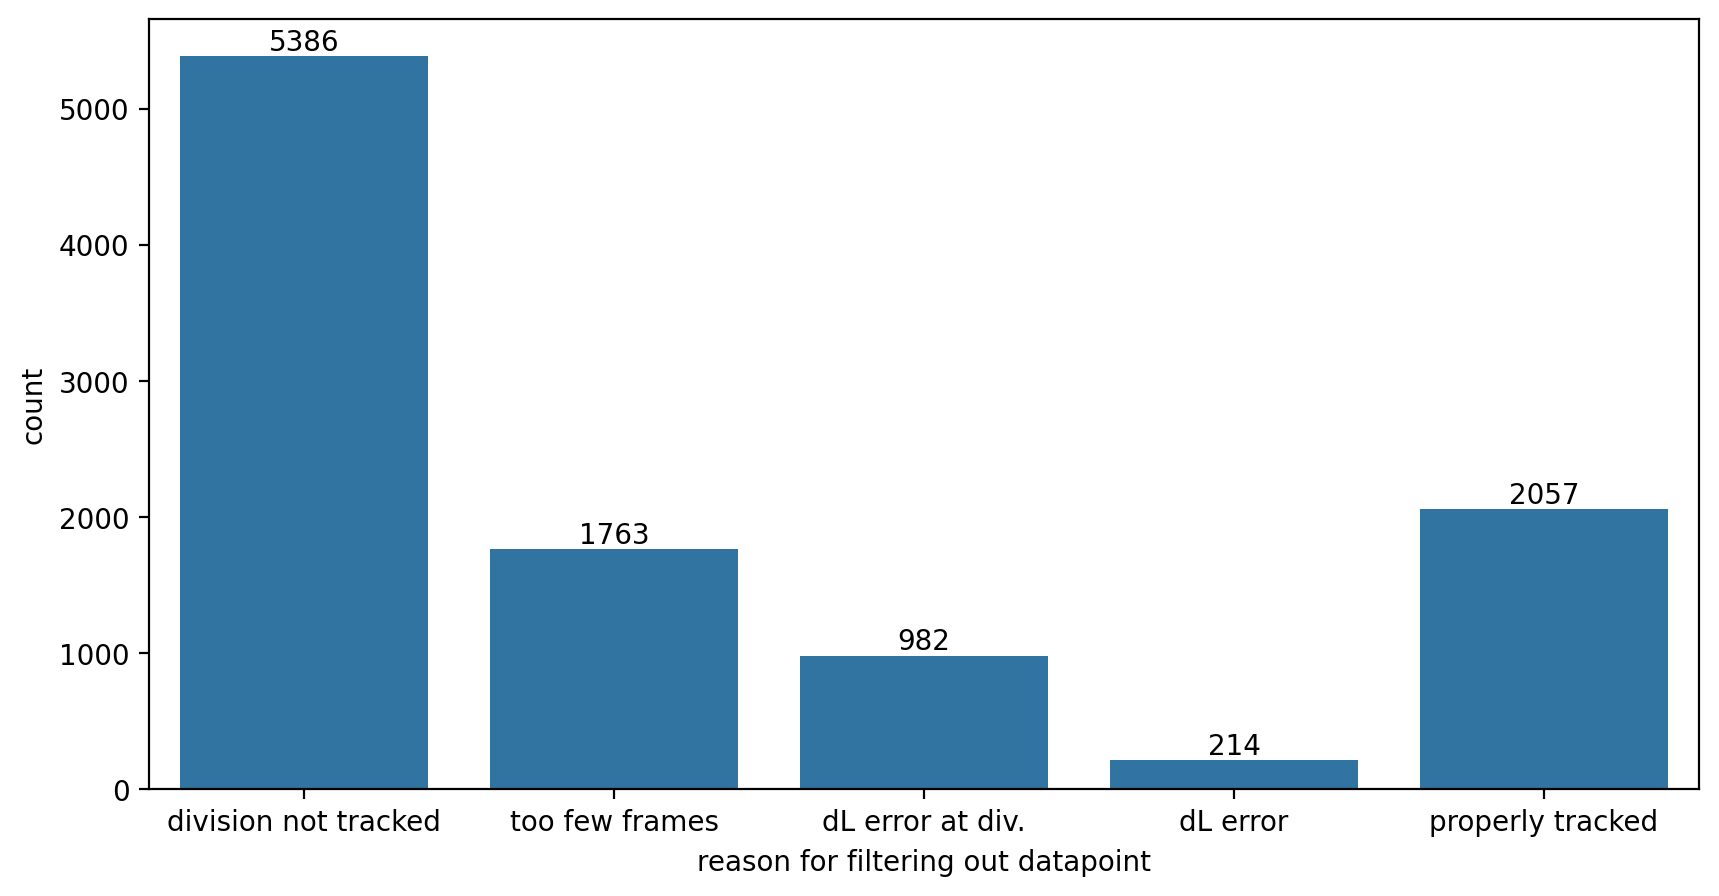

In [50]:
df_stats = pd.DataFrame([[k,v] for k,v in reason_skipped.items()],columns=['reason','count'])
ax = sns.barplot(data=df_stats, x='reason', y='count')
ax.set(xlabel = 'reason for filtering out datapoint')
ax.bar_label(ax.containers[0]);
#fig.savefig(image_dir / 'reasons_for_datapoint_removal_Psy.pdf')

---

## Store Data

In [51]:
#out_name = save_dir / 'filtered_data_Psy.csv'
#df_paired.to_csv(out_name)

---

## Show number of data points per strain

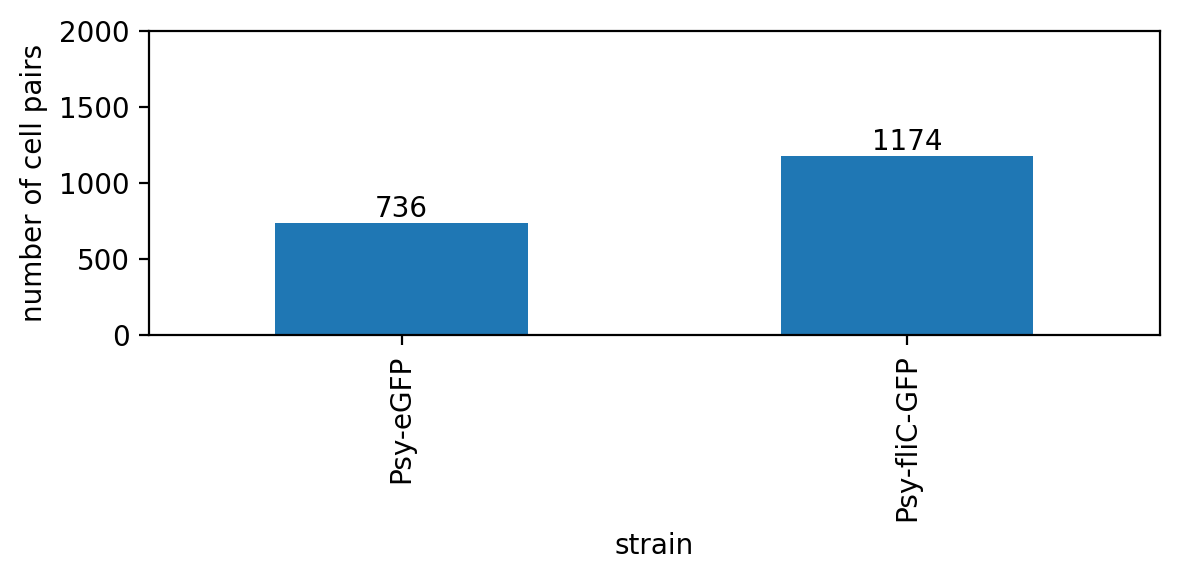

In [52]:
first_frame = df_paired.groupby('uni_par_id').first()

fig,axs = plt.subplots(figsize=(6,3))
num_lin_per_strain = first_frame.groupby('strain').size() 
num_lin_per_strain.head(n=18)
ax = num_lin_per_strain.plot(kind='bar')
ax.bar_label(ax.containers[0]);

ax.set_ylabel('number of cell pairs')
ax.set_ylim((0,2000))
fig.tight_layout()

#fig.savefig(image_dir / 'number_cell_pairs_per_strain_Psy.pdf')

---

## Psy eGFP vs fliC-GFP: fluorescence intensity vs. elongation rate

Psy eGFP: PearsonRResult(statistic=-0.026178159244001582, pvalue=0.46192474153827584)
Psy fliC-GFP: PearsonRResult(statistic=-0.17066011459064095, pvalue=1.0353356748124454e-09)


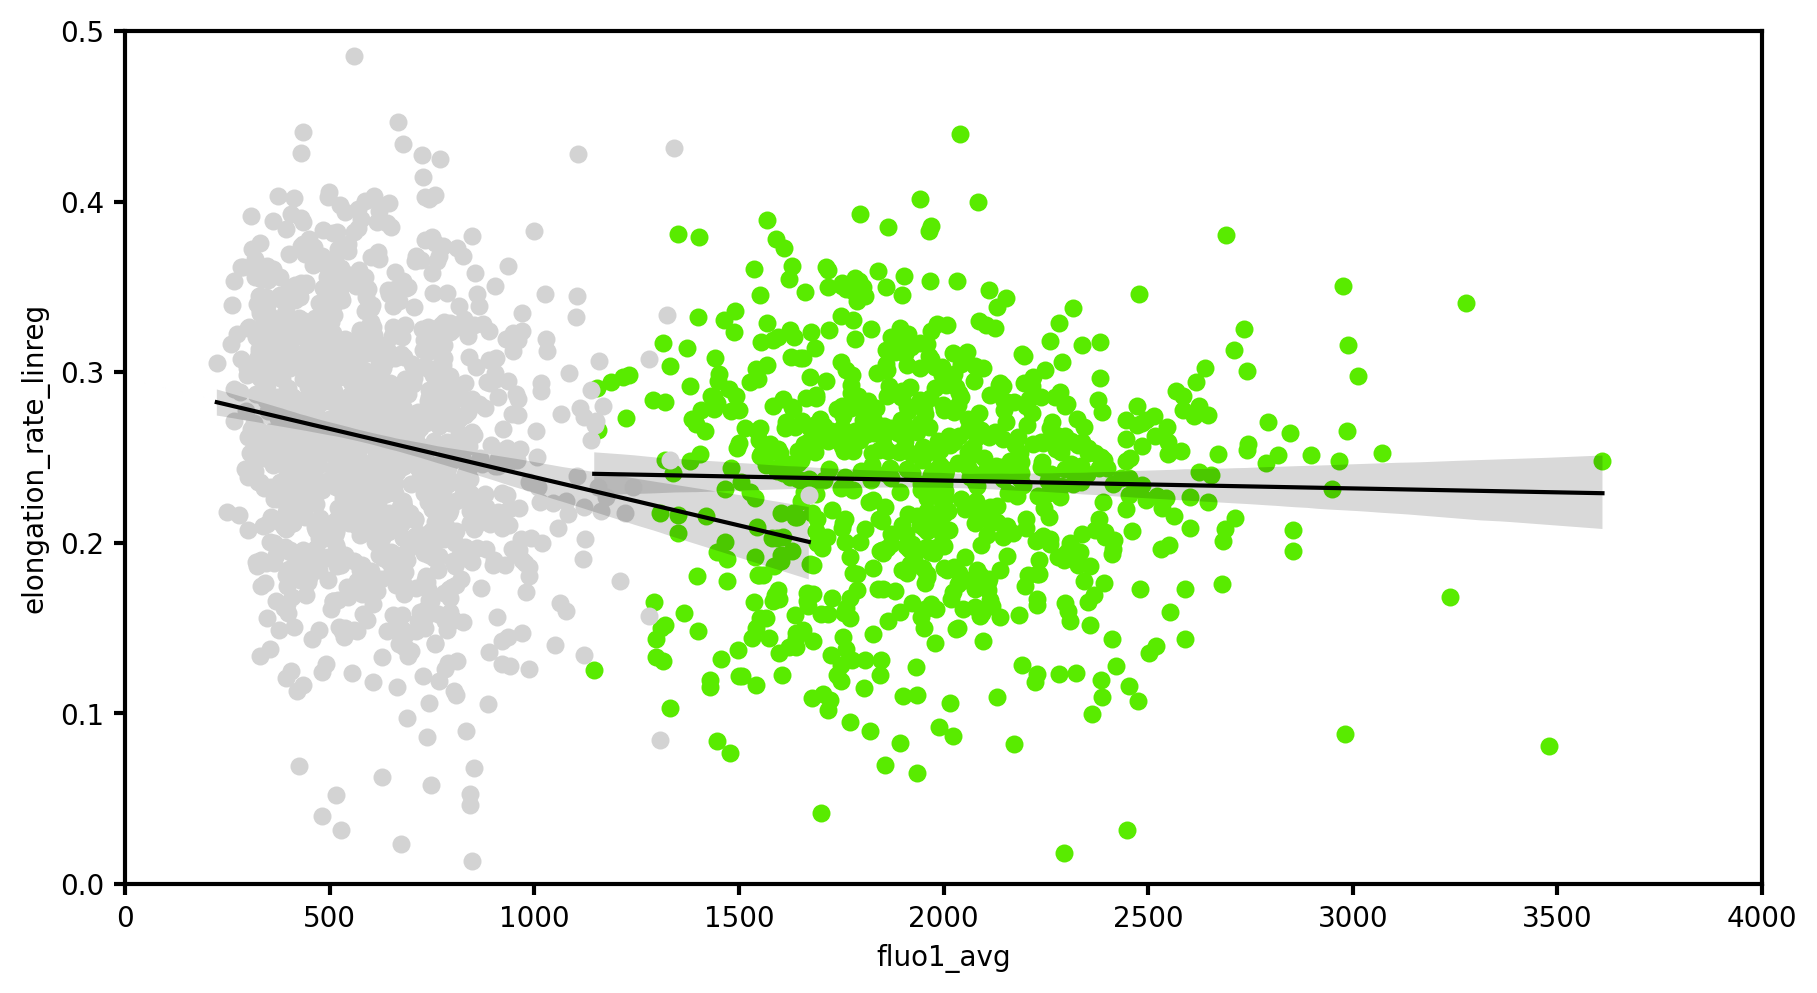

In [73]:
#extract 1 line per cell and get only useful columns
mydata_plot = df_list[0].iloc[0:1,:]

for i in range(1,len(df_list)):
    mydata_plot = pd.concat([mydata_plot, df_list[i].iloc[0:1,:]])

# Filter out cells with NaN values
mydata_plot = mydata_plot.dropna(subset=['elongation_rate_linreg','fluo1_avg'])

# Select only one strain
mydata_plot_fliC = mydata_plot.loc[mydata_plot['strain'] == 'Psy-fliC-GFP',:]
mydata_plot_eGFP = mydata_plot.loc[mydata_plot['strain'] == 'Psy-eGFP',:]

#Pearson correlation coefficient 
res_pearson_eGFP = scipy.stats.pearsonr(x=mydata_plot_eGFP['elongation_rate_linreg'], y=mydata_plot_eGFP['fluo1_avg']) # Pearson's r
res_pearson_fliC = scipy.stats.pearsonr(x=mydata_plot_fliC['elongation_rate_linreg'], y=mydata_plot_fliC['fluo1_avg']) # Pearson's r
print('Psy eGFP: ' + str(res_pearson_eGFP))
print('Psy fliC-GFP: ' + str(res_pearson_fliC))


#Plot fluorescence intensity vs elongation rate for both Psy eGFP and fliC-GFP strains

fig, axs = plt.subplots(figsize=(9,5))
g = sns.regplot(data = mydata_plot_eGFP, x='fluo1_avg', y='elongation_rate_linreg', 
            color = mypalette[0], line_kws={'linewidth':1.5, 'alpha':1, 'color':'black'}, 
            scatter_kws={'alpha':1,'s':30, 'color':'#59eb00'})
sns.regplot(data = mydata_plot_fliC, x='fluo1_avg', y='elongation_rate_linreg', 
            color = mypalette[1], line_kws={'linewidth':1.5, 'alpha':1, 'color':'black'}, 
            scatter_kws={'alpha':1,'s':30, 'color':'lightgrey'})
#sns.kdeplot(data = mydata_plot, x = 'fluo1_avg', linewidth = 1.5, hue='strain', palette=['dimgrey','limegreen'], fill = True, bw_adjust=2)


#Make the plot nicer
plt.tight_layout(w_pad=1)
plt.tick_params(length = 4, width=1.5)
plt.ylim(0,0.5)
plt.xlim(0,4000)
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(1.5)

im_name = image_dir / 'Psy_eGFP_fliC-GFP_fluo_vs_elongation.pdf'
#fig.get_figure().savefig(im_name, dpi=300,transparent=True)

Psy eGFP: PearsonRResult(statistic=-0.026178159244001582, pvalue=0.46192474153827584)
Psy fliC-GFP: PearsonRResult(statistic=-0.17066011459064095, pvalue=1.0353356748124454e-09)


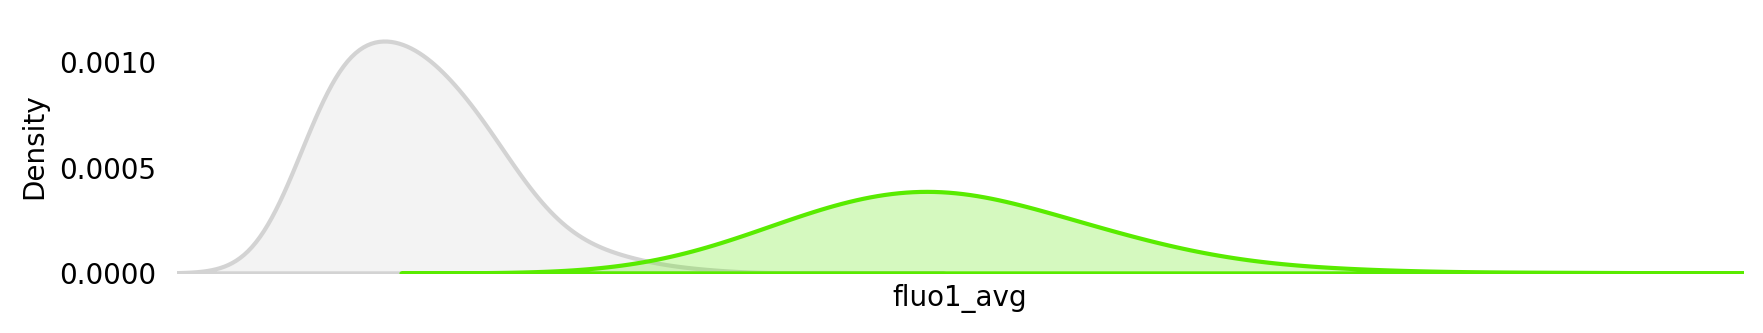

In [165]:
#extract 1 line per cell and get only useful columns
mydata_plot = df_list[0].iloc[0:1,:]

for i in range(1,len(df_list)):
    mydata_plot = pd.concat([mydata_plot, df_list[i].iloc[0:1,:]])

# Filter out cells with NaN values
mydata_plot = mydata_plot.dropna(subset=['elongation_rate_linreg','fluo1_avg'])

# Select only one strain
mydata_plot_fliC = mydata_plot.loc[mydata_plot['strain'] == 'Psy-fliC-GFP',:]
mydata_plot_eGFP = mydata_plot.loc[mydata_plot['strain'] == 'Psy-eGFP',:]

#Pearson correlation coefficient 
res_pearson_eGFP = scipy.stats.pearsonr(x=mydata_plot_eGFP['elongation_rate_linreg'], y=mydata_plot_eGFP['fluo1_avg']) # Pearson's r
res_pearson_fliC = scipy.stats.pearsonr(x=mydata_plot_fliC['elongation_rate_linreg'], y=mydata_plot_fliC['fluo1_avg']) # Pearson's r
print('Psy eGFP: ' + str(res_pearson_eGFP))
print('Psy fliC-GFP: ' + str(res_pearson_fliC))


#Plot the distribution of fluorescence intensity for both Psy eGFP and fliC-GFP strains

fig, axs = plt.subplots(figsize=(9,2))
g = sns.kdeplot(data = mydata_plot, x = 'fluo1_avg', linewidth = 1.5, hue='strain', palette=['#59eb00','lightgrey'], fill = True, bw_adjust=2)


#Make the plot nicer
axs.get_legend().remove()
plt.tight_layout(w_pad=1)
plt.tick_params(length = 4, width=1.5)
plt.ylim(0,0.0012)
plt.xlim(0,4000)
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_visible(False)
#axs.spines['left'].set_linewidth(1.5)
axs.tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)
axs.spines['bottom'].set_linewidth(1.5)
#axs.spines['bottom'].set_visible(True)
#axs.spines['bottom'].set_color('white')

im_name = image_dir / 'Psy_eGFP_fliC-GFP_fluo_distribution_noaxis_trsprt.pdf'
#fig.get_figure().savefig(im_name, dpi=300,transparent=True)

0.24350825894601053
0.26094996322246783
n_eGFP: 792
n_fliC: 1263


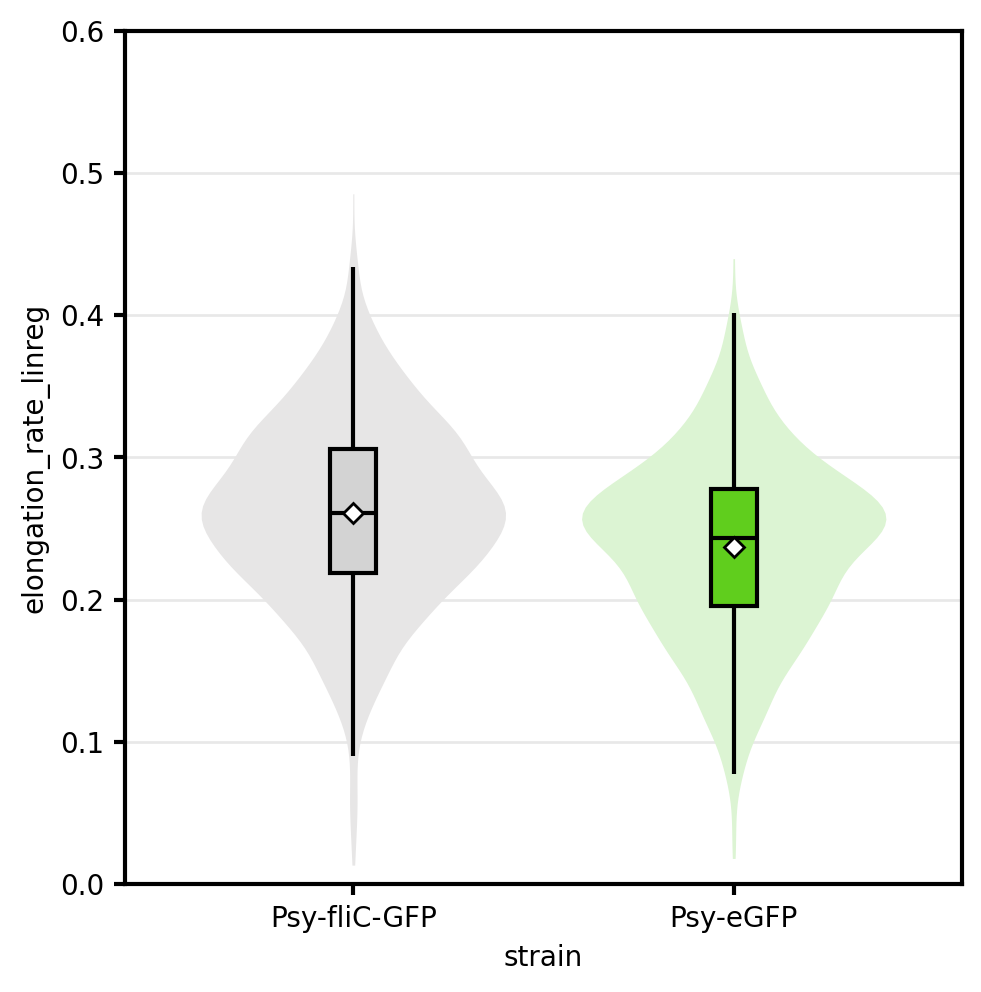

In [166]:
#Get the Median elongation rate of each population
med_eGFP = mydata_plot.loc[mydata_plot['strain'] == 'Psy-eGFP','elongation_rate_linreg'].median()
med_fliC = mydata_plot.loc[mydata_plot['strain'] == 'Psy-fliC-GFP','elongation_rate_linreg'].median()
print(med_eGFP)
print(med_fliC)

n_eGFP = mydata_plot_eGFP.shape[0]
n_fliC = mydata_plot_fliC.shape[0]
print('n_eGFP: ' + str(n_eGFP))
print('n_fliC: ' + str(n_fliC))

#Plot distributions for each strain
mypalette = ['#E7E6E6','#dafacd'] #'#59eb00']

fig, axs = plt.subplots(figsize=(5,5))

#sns.swarmplot(ax = axs, data=mydata_plot, x='strain',y='elongation_rate_linreg',
#                  s = 2.25, hue ='strain', palette=mypalette, zorder = 1, dodge=False,
#                  order=['Psy-fliC-GFP','Psy-eGFP'], hue_order=['Psy-fliC-GFP','Psy-eGFP'], legend=False)

sns.violinplot(ax = axs, data=mydata_plot, x='strain',y='elongation_rate_linreg',
               hue ='strain', order=['Psy-fliC-GFP','Psy-eGFP'], hue_order=['Psy-fliC-GFP','Psy-eGFP'],
               palette=mypalette, fill = True, linecolor = 'black', cut = 0, inner = None, linewidth = 0,
               zorder = 1, legend=False)

mypalette_box = ['lightgrey','#59eb00']
sns.boxplot(ax = axs, data=mydata_plot, x='strain', y='elongation_rate_linreg', 
            order=['Psy-fliC-GFP','Psy-eGFP'], hue_order=['Psy-fliC-GFP','Psy-eGFP'], hue ='strain', palette=mypalette_box,
            linewidth = 1.5, width = 0.12, zorder=2, linecolor = 'black',
            showmeans = True, meanprops = {'marker': 'D', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize':5},
            showfliers=False, showbox=True, showcaps=False, legend=False)

#Make the plot nicer
plt.tight_layout(w_pad=1)
plt.tick_params(length = 4, width=1.5)
plt.ylim(0,0.6)
axs.grid(axis='y', color = 'lightgrey', alpha = 0.5, linewidth=1, zorder = 0)
axs.set_axisbelow(True)
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(1.5)
axs.set_xlim(-0.6, 1.6)

im_name = image_dir / 'growth_rates_strains_Psy_fliC_eGFP.pdf'
#fig.get_figure().savefig(im_name, dpi=300,transparent=True)

res_levene p-value = 0.4002652362063591
res_shapiro_fliC p-value = 0.003729337127879262
res_shapiro_eGFP p-value = 0.004436545539647341
t-test p-value = 7.744207438957245e-16
!!! t-test assumptions are NOT verfied !!!
mwu p-value = 7.696114721095138e-15


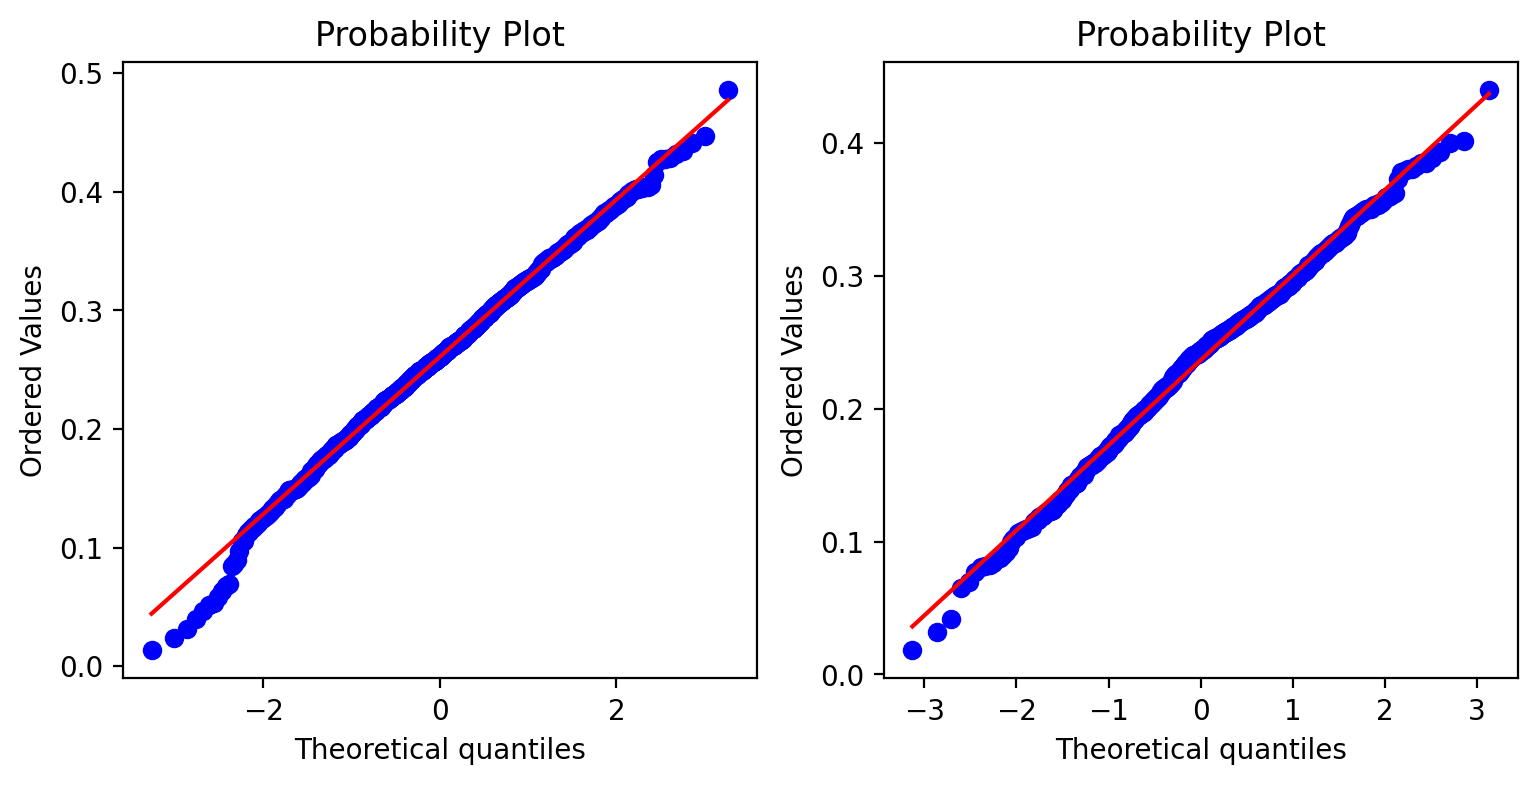

In [167]:
##t-test

#Check t-test assumptions
#Homogeneity of variances - levene test
res_levene = scipy.stats.levene(mydata_plot_fliC['elongation_rate_linreg'],mydata_plot_eGFP['elongation_rate_linreg'])
print('res_levene p-value = ' + str(res_levene[1]))

#Normality - Shapiro-Wilk test
res_shapiro_fliC = scipy.stats.shapiro(mydata_plot_fliC['elongation_rate_linreg'])
res_shapiro_eGFP = scipy.stats.shapiro(mydata_plot_eGFP['elongation_rate_linreg'])
print('res_shapiro_fliC p-value = ' + str(res_shapiro_fliC[1]))
print('res_shapiro_eGFP p-value = ' + str(res_shapiro_eGFP[1]))

fig, axs = plt.subplots(figsize=(9,4), ncols = 2)
scipy.stats.probplot(mydata_plot_fliC['elongation_rate_linreg'], dist='norm', plot = axs[0])
scipy.stats.probplot(mydata_plot_eGFP['elongation_rate_linreg'], dist='norm', plot = axs[1])

#t-test
res_ttest = scipy.stats.ttest_ind(mydata_plot_fliC['elongation_rate_linreg'],mydata_plot_eGFP['elongation_rate_linreg'])
print('t-test p-value = ' + str(res_ttest[1]))

if (res_levene[1] < 0.05) or (res_shapiro_fliC[1] < 0.05) or (res_shapiro_eGFP[1] < 0.05):
    print('!!! t-test assumptions are NOT verfied !!!')

#Mann Whitney test (if postulates for t-test are not validated)
res_mwu = scipy.stats.mannwhitneyu(mydata_plot_fliC['elongation_rate_linreg'],mydata_plot_eGFP['elongation_rate_linreg'])
print('mwu p-value = ' + str(res_mwu[1]))

---

## Psy fliC-GFP: Correlation between fluorescence and growth rates

PearsonRResult(statistic=-0.17066011459064095, pvalue=1.0353356748124454e-09)
SignificanceResult(statistic=-0.1864791527896433, pvalue=2.4002327270961227e-11)


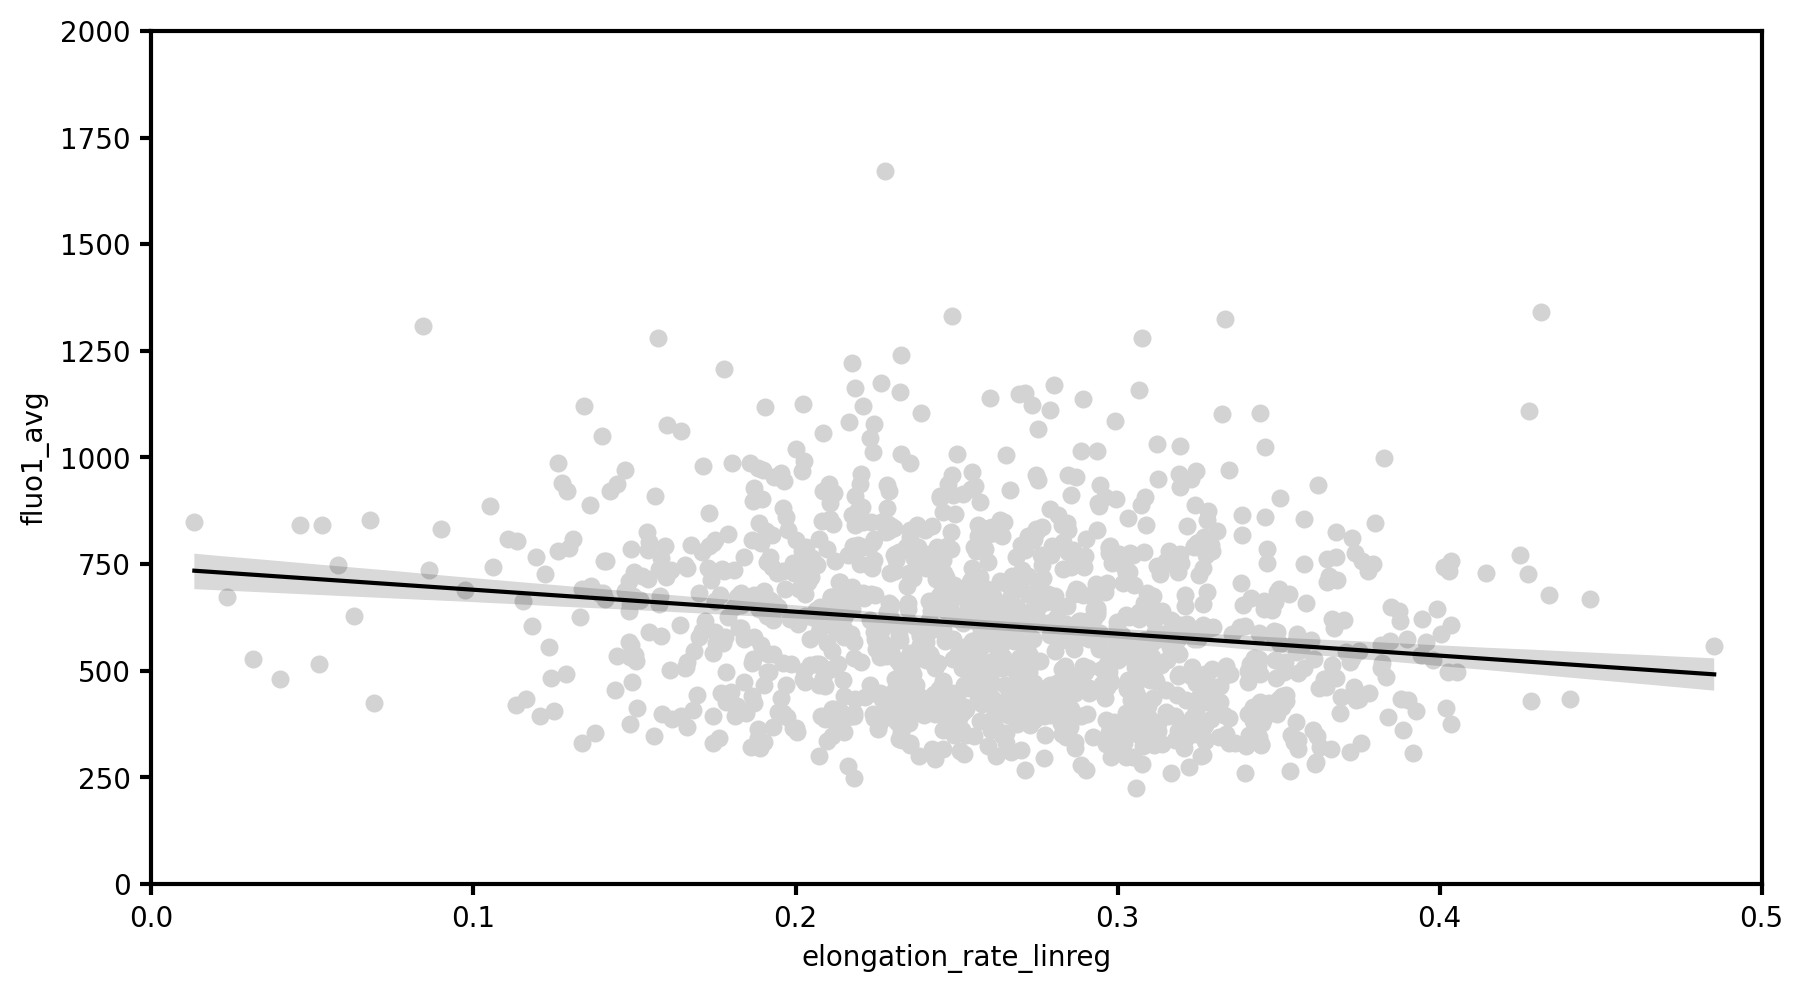

In [172]:
#extract 1 line per cell and get only useful columns
mydata_plot = df_list[0].iloc[0:1,:]

for i in range(1,len(df_list)):
    mydata_plot = pd.concat([mydata_plot, df_list[i].iloc[0:1,:]])

# Select only one strain
mydata_plot_fliC = mydata_plot.loc[mydata_plot['strain'] == 'Psy-fliC-GFP',:]

# Filter out cells with NaN values
mydata_plot_fliC=mydata_plot_fliC.dropna(subset=['elongation_rate_linreg','fluo1_avg'])

#Pearson correlation coefficient 
res_pearson = scipy.stats.pearsonr(x=mydata_plot_fliC['fluo1_avg'],y=mydata_plot_fliC['elongation_rate_linreg']) # Pearson's r
print(res_pearson)

#Pearson correlation coefficient 
res_spearman = scipy.stats.spearmanr(mydata_plot_fliC['fluo1_avg'],mydata_plot_fliC['elongation_rate_linreg']) # Spearman's rho
print(res_spearman)

#Plot the data
fig, axs = plt.subplots(figsize=(9,5))
sns.regplot(ax=axs, data = mydata_plot_fliC, x='elongation_rate_linreg', y='fluo1_avg', 
            #color = '#59eb00', 
            line_kws={'linewidth':1.5, 'alpha':1, 'color':'black'}, 
            scatter_kws={'alpha':1,'s':30, 'color':'lightgrey'})

#Make the plot nicer
plt.tight_layout(w_pad=1)
plt.tick_params(length = 4, width=1.5)
plt.xlim(0,0.5)
plt.ylim(0,2000)
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(1.5)

im_name = image_dir / 'corr_growth_fluo_Psy.pdf'
#fig.get_figure().savefig(im_name, dpi=300)

fluo_low_median: 0.26948017495276677
fluo_high_median: 0.25190317713942334
fluo_low_mean: 0.2707885457827989
fluo_high_mean: 0.25064781717518897
!!! Cells with high flagellum expression divide  6.52 % slower than cells with low flagellum expression!!!


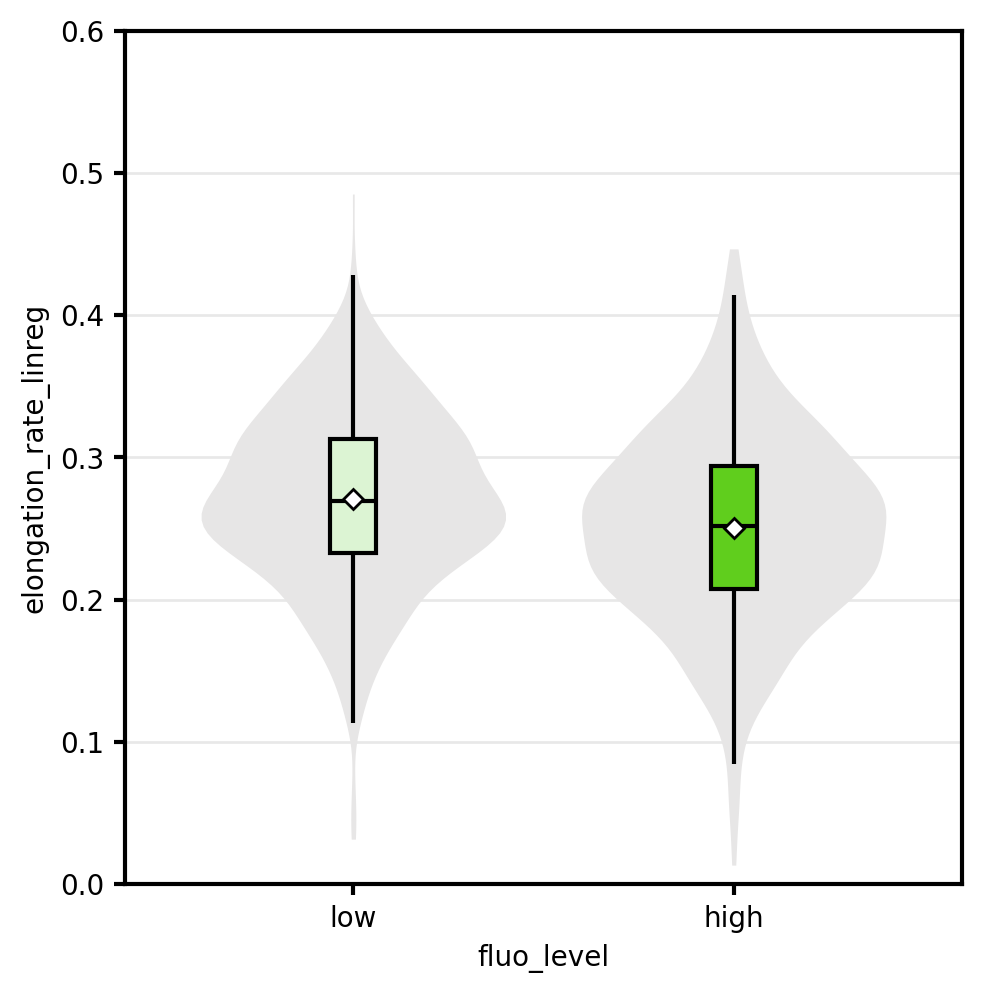

In [180]:
###Split the population according to quartiles of fluorescence intensity

# Select only the strain of interest, here fliC-GFP
mydata_plot_fliC = mydata_plot.loc[mydata_plot['strain'] == 'Psy-fliC-GFP',:]

# Filter out cells with NaN values
mydata_plot_fliC=mydata_plot_fliC.dropna(subset=['elongation_rate_linreg','fluo1_avg'])


# Split the dataset based on cell fluorescence intensity (high vs low)
mydata_plot_fliC['fluo_level'] = 'NA'
mydata_plot_fliC.loc[mydata_plot_fliC['fluo1_avg'] <= fluo_quantiles.loc[0.5],'fluo_level'] = 'low'
mydata_plot_fliC.loc[mydata_plot_fliC['fluo1_avg'] >= fluo_quantiles.loc[0.5],'fluo_level'] = 'high'

mydata_plot_fliC_low = mydata_plot_fliC.loc[mydata_plot_fliC['fluo_level'] == 'low',:]
mydata_plot_fliC_high = mydata_plot_fliC.loc[mydata_plot_fliC['fluo_level'] == 'high',:]

#Get the median and mean values of high and low gfp subpopulations
fluo_low_median = mydata_plot_fliC_low['elongation_rate_linreg'].median()
print('fluo_low_median: ' + str(fluo_low_median))
fluo_high_median = mydata_plot_fliC_high['elongation_rate_linreg'].median()
print('fluo_high_median: ' + str(fluo_high_median))

fluo_low_mean = mydata_plot_fliC_low['elongation_rate_linreg'].mean()
print('fluo_low_mean: ' + str(fluo_low_mean))
fluo_high_mean = mydata_plot_fliC_high['elongation_rate_linreg'].mean()
print('fluo_high_mean: ' + str(fluo_high_mean))

#Calculate the relative cost of expressing the flagellum
extra_time_to_divide = round((fluo_low_median - fluo_high_median)/fluo_low_median,4) # Percentage of extr time it takes to divide when expressing fliC
print('!!! Cells with high flagellum expression divide ', extra_time_to_divide*100, '% slower than cells with low flagellum expression!!!')


#Plot distributions for each strain
mypalette = ['#E7E6E6','#E7E6E6'] #'#59eb00']

fig, axs = plt.subplots(figsize=(5,5))
sns.violinplot(ax = axs, data=mydata_plot_fliC, x='fluo_level',y='elongation_rate_linreg',
               order=['low','high'], hue_order=['low','high'], hue ='fluo_level',
               palette=mypalette, fill = True, linecolor = 'black', cut = 0, inner = None, linewidth = 0,
               zorder = 1, legend=False)

mypalette_box = ['#dafacd','#59eb00']
sns.boxplot(ax = axs, data=mydata_plot_fliC, x='fluo_level', y='elongation_rate_linreg', 
            order=['low','high'], hue_order=['low','high'], hue ='fluo_level', palette=mypalette_box,
            linewidth = 1.5, width = 0.12, zorder=2, linecolor = 'black',
            showmeans = True, meanprops = {'marker': 'D', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize':5},
            showfliers=False, showbox=True, showcaps=False, legend=False)



#Make the plot nicer
plt.tight_layout(w_pad=1)
plt.tick_params(length = 4, width=1.5)
#plt.ylim(-0.05,0.65)
plt.ylim(0,0.6)
axs.grid(axis='y', color = 'lightgrey', alpha = 0.5, linewidth=1, zorder = 0)
axs.set_axisbelow(True)
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(1.5)
axs.set_xlim(-0.6, 1.6)

im_name = image_dir / 'growth_rates_high_low_fluo_Psy_violin.pdf'
#fig.get_figure().savefig(im_name, dpi=300,transparent=True)

res_levene p-value = 0.05194336513911588
res_shapiro_low p-value = 0.011396852321922779
res_shapiro_high p-value = 0.2701006233692169
t-test p-value = 5.753549001527247e-08
!!! t-test assumptions are NOT verfied !!!
mwu p-value = 3.6198306600573315e-08


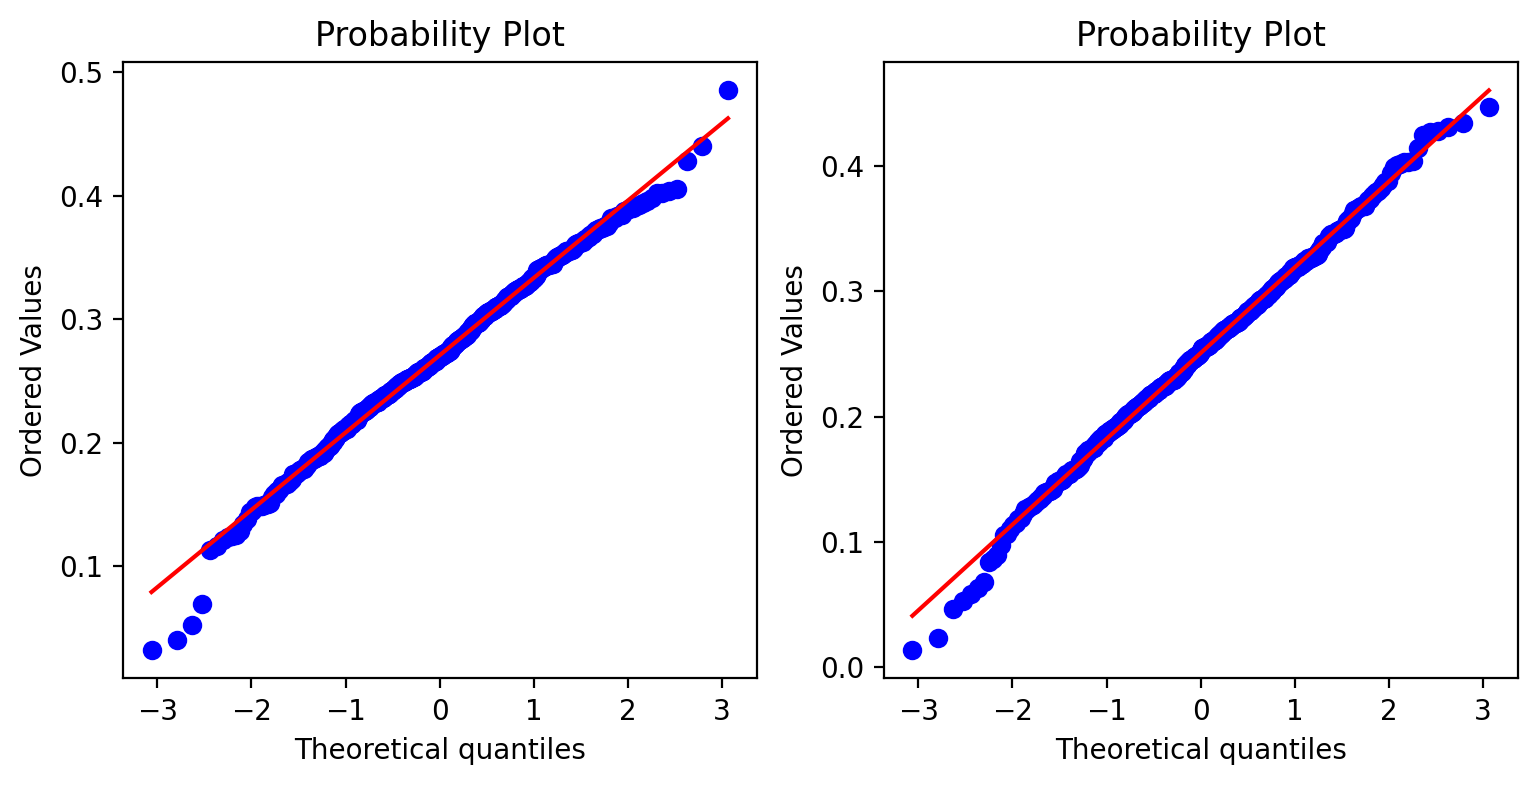

In [176]:
##t-test

#Check t-test assumptions
#Homogeneity of variances - levene test
res_levene = scipy.stats.levene(mydata_plot_fliC_low['elongation_rate_linreg'],mydata_plot_fliC_high['elongation_rate_linreg'])
print('res_levene p-value = ' + str(res_levene[1]))

#Normality - Shapiro-Wilk test
res_shapiro_low = scipy.stats.shapiro(mydata_plot_fliC_low['elongation_rate_linreg'])
res_shapiro_high = scipy.stats.shapiro(mydata_plot_fliC_high['elongation_rate_linreg'])
print('res_shapiro_low p-value = ' + str(res_shapiro_low[1]))
print('res_shapiro_high p-value = ' + str(res_shapiro_high[1]))

fig, axs = plt.subplots(figsize=(9,4), ncols = 2)
scipy.stats.probplot(mydata_plot_fliC_low['elongation_rate_linreg'], dist='norm', plot = axs[0])
scipy.stats.probplot(mydata_plot_fliC_high['elongation_rate_linreg'], dist='norm', plot = axs[1])

#t-test
res_ttest = scipy.stats.ttest_ind(mydata_plot_fliC_low['elongation_rate_linreg'],mydata_plot_fliC_high['elongation_rate_linreg'])
print('t-test p-value = ' + str(res_ttest[1]))

if (res_levene[1] < 0.05) or (res_shapiro_low[1] < 0.05) or (res_shapiro_high[1] < 0.05):
    print('!!! t-test assumptions are NOT verfied !!!')

#Mann Whitney test (if postulates for t-test are not validated)
res_mwu = scipy.stats.mannwhitneyu(mydata_plot_fliC_low['elongation_rate_linreg'],mydata_plot_fliC_high['elongation_rate_linreg'])
print('mwu p-value = ' + str(res_mwu[1]))

0.10    370.781497
0.25    448.038728
0.50    586.262270
0.75    737.690009
0.90    860.972684
Name: fluo1_avg, dtype: float64
fluo_low25_median: 0.2713426231062649
fluo_high25_median: 0.24338520657145266
fluo_low25_mean: 0.27363508370281603
fluo_high25_mean: 0.24506077091899633
!!! Cells with high flagellum expression divide  10.299999999999999 % slower than cells with low flagellum expression!!!


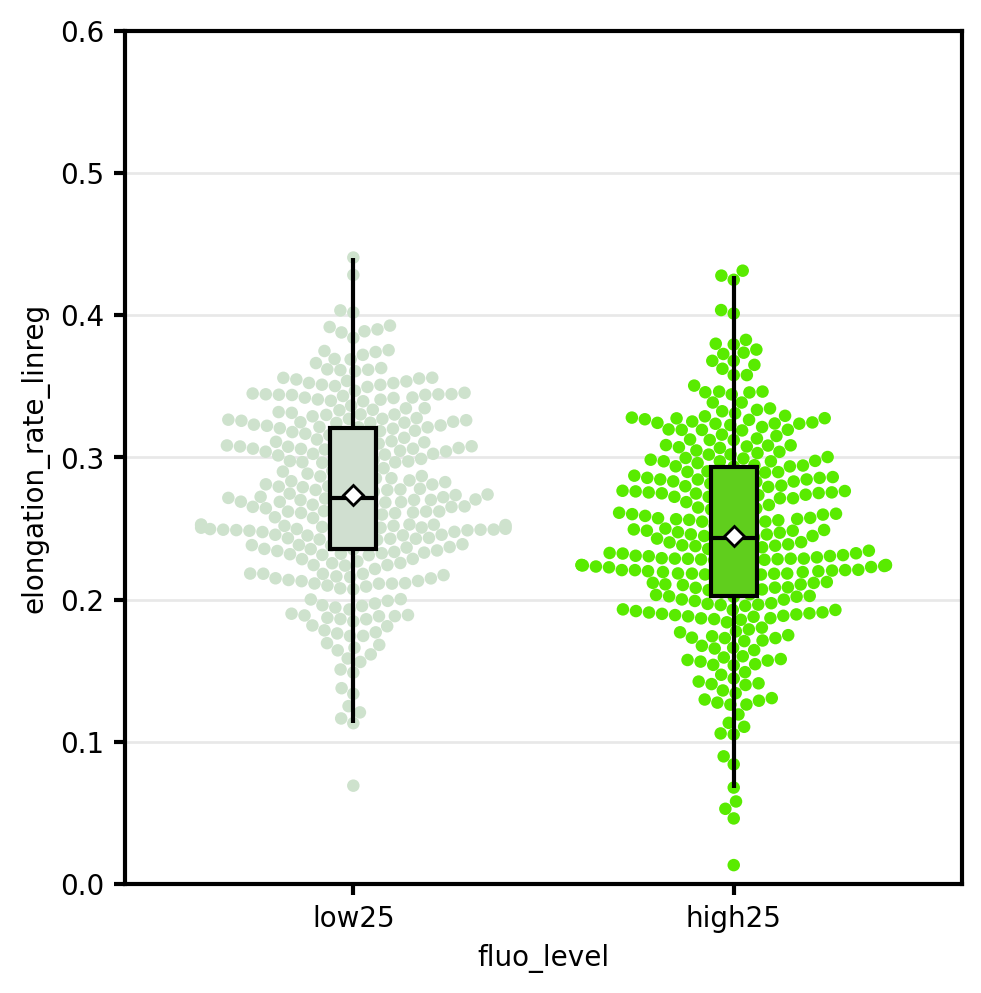

In [177]:
###Split the population according to quartiles of fluorescence intensity

# Select only the strain of interest, here fliC-GFP
mydata_plot_fliC = mydata_plot.loc[mydata_plot['strain'] == 'Psy-fliC-GFP',:]

# Filter out cells with NaN values
mydata_plot_fliC=mydata_plot_fliC.dropna(subset=['elongation_rate_linreg','fluo1_avg'])

fluo_quantiles = mydata_plot_fliC['fluo1_avg'].quantile([0.1,0.25,0.5,0.75,0.9])
print(fluo_quantiles)

# Split the dataset based on cell fluorescence intensity (high vs low)
mydata_plot_fliC['fluo_level'] = 'mid50'
mydata_plot_fliC.loc[mydata_plot_fliC['fluo1_avg'] <= fluo_quantiles.loc[0.25],'fluo_level'] = 'low25'
mydata_plot_fliC.loc[mydata_plot_fliC['fluo1_avg'] >= fluo_quantiles.loc[0.75],'fluo_level'] = 'high25'

mydata_plot_fliC_low25 = mydata_plot_fliC.loc[mydata_plot_fliC['fluo_level'] == 'low25',:]
mydata_plot_fliC_high25 = mydata_plot_fliC.loc[mydata_plot_fliC['fluo_level'] == 'high25',:]

mydata_plot_fliC_extremes25 = mydata_plot_fliC.loc[mydata_plot_fliC['fluo_level'] != 'mid50',:]

#Get the median and mean values of high and low gfp subpopulations
fluo_low25_median = mydata_plot_fliC_low25['elongation_rate_linreg'].median()
print('fluo_low25_median: ' + str(fluo_low25_median))
fluo_high25_median = mydata_plot_fliC_high25['elongation_rate_linreg'].median()
print('fluo_high25_median: ' + str(fluo_high25_median))

fluo_low25_mean = mydata_plot_fliC_low25['elongation_rate_linreg'].mean()
print('fluo_low25_mean: ' + str(fluo_low25_mean))
fluo_high25_mean = mydata_plot_fliC_high25['elongation_rate_linreg'].mean()
print('fluo_high25_mean: ' + str(fluo_high25_mean))

#Calculate the relative cost of expressing the flagellum
extra_time_to_divide = round((fluo_low25_median - fluo_high25_median)/fluo_low25_median,4) # Percentage of extr time it takes to divide when expressing fliC
print('!!! Cells with high flagellum expression divide ', extra_time_to_divide*100, '% slower than cells with low flagellum expression!!!')

#Plot distributions for each quantiles
mypalette = ['#cee2cd','#59eb00']

fig, axs = plt.subplots(figsize=(5,5))

sns.swarmplot(ax = axs, data=mydata_plot_fliC_extremes25, x='fluo_level',y='elongation_rate_linreg',
                  s = 4.5, hue ='fluo_level', palette=mypalette, zorder = 1, dodge=False,
                  order=['low25','high25'], hue_order=['low25','high25'], legend=False)

sns.boxplot(ax = axs, data=mydata_plot_fliC_extremes25, x='fluo_level', y='elongation_rate_linreg', 
            order=['low25','high25'], hue_order=['low25','high25'], hue ='fluo_level', palette=mypalette,
            linewidth = 1.5, width = 0.12, zorder=2, linecolor = 'black',
            showmeans = True, meanprops = {'marker': 'D', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize':5},
            showfliers=False, showbox=True, showcaps=False, legend=False)


#Make the plot nicer
plt.tight_layout(w_pad=1)
plt.tick_params(length = 4, width=1.5)
#plt.ylim(-0.05,0.65)
plt.ylim(0,0.6)
axs.grid(axis='y', color = 'lightgrey', alpha = 0.5, linewidth=1, zorder = 0)
axs.set_axisbelow(True)
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(1.5)
axs.set_xlim(-0.6, 1.6)

im_name = image_dir / 'growth_rates_high25_low25_fluo_Psy.pdf'
#fig.get_figure().savefig(im_name, dpi=300)

res_levene p-value = 0.08319609987324543
res_shapiro_low p-value = 0.41101154685020447
res_shapiro_high p-value = 0.45295143127441406
t-test p-value = 6.302091104198794e-08
mwu p-value = 8.245117038315261e-08


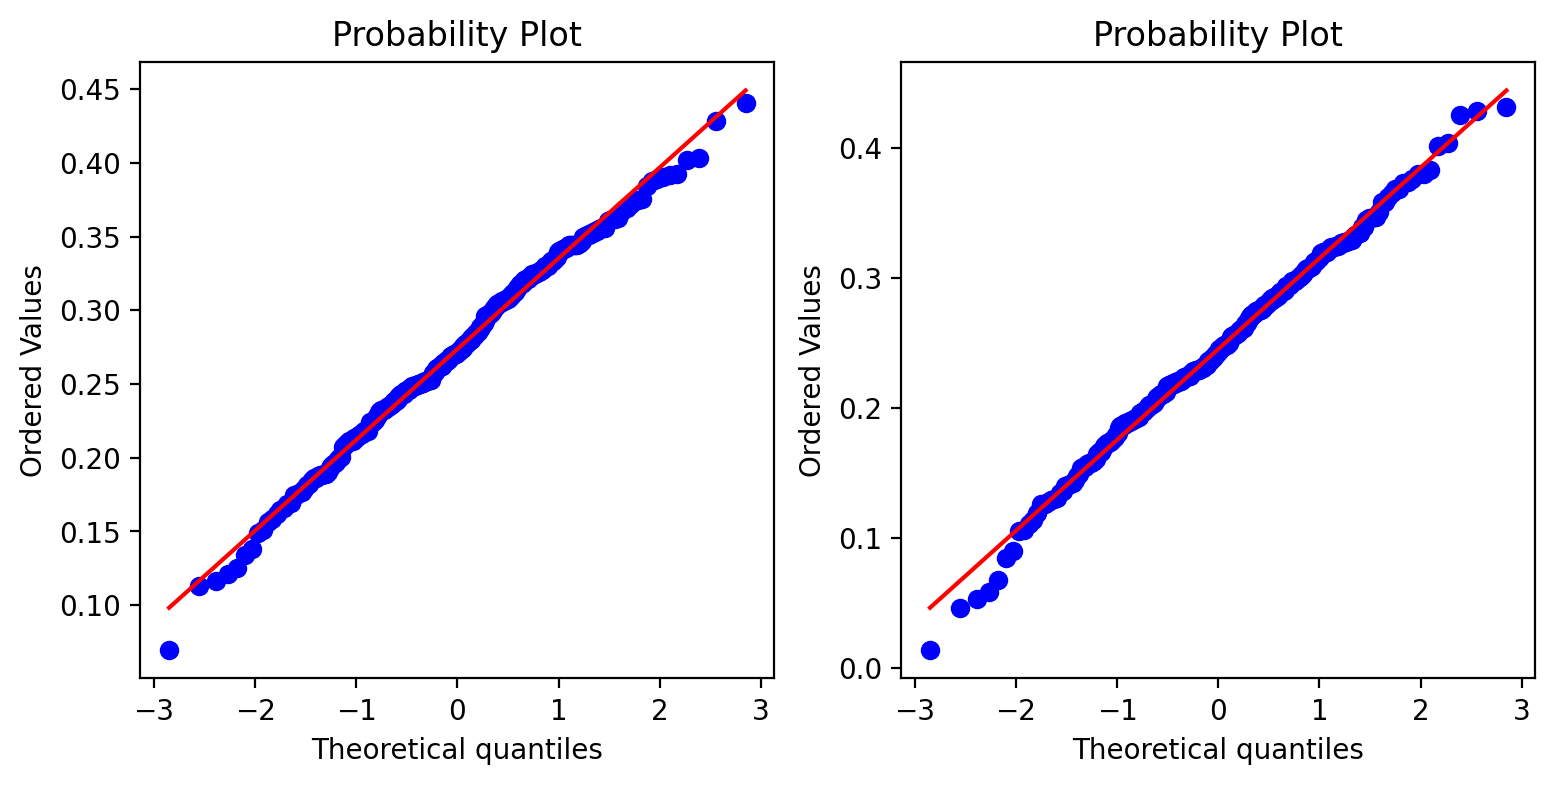

In [178]:
##t-test

#Check t-test assumptions
#Homogeneity of variances - levene test
res_levene = scipy.stats.levene(mydata_plot_fliC_low25['elongation_rate_linreg'],mydata_plot_fliC_high25['elongation_rate_linreg'])
print('res_levene p-value = ' + str(res_levene[1]))

#Normality - Shapiro-Wilk test
res_shapiro_low = scipy.stats.shapiro(mydata_plot_fliC_low25['elongation_rate_linreg'])
res_shapiro_high = scipy.stats.shapiro(mydata_plot_fliC_high25['elongation_rate_linreg'])
print('res_shapiro_low p-value = ' + str(res_shapiro_low[1]))
print('res_shapiro_high p-value = ' + str(res_shapiro_high[1]))

fig, axs = plt.subplots(figsize=(9,4), ncols = 2)
scipy.stats.probplot(mydata_plot_fliC_low25['elongation_rate_linreg'], dist='norm', plot = axs[0])
scipy.stats.probplot(mydata_plot_fliC_high25['elongation_rate_linreg'], dist='norm', plot = axs[1])

#t-test
res_ttest = scipy.stats.ttest_ind(mydata_plot_fliC_low25['elongation_rate_linreg'],mydata_plot_fliC_high25['elongation_rate_linreg'])
print('t-test p-value = ' + str(res_ttest[1]))

if (res_levene[1] < 0.05) or (res_shapiro_low[1] < 0.05) or (res_shapiro_high[1] < 0.05):
    print('!!! t-test assumptions are NOT verfied !!!')

#Mann Whitney test (if postulates for t-test are not validated)
res_mwu = scipy.stats.mannwhitneyu(mydata_plot_fliC_low25['elongation_rate_linreg'],mydata_plot_fliC_high25['elongation_rate_linreg'])
print('mwu p-value = ' + str(res_mwu[1]))